### 1- Project Introduction

#### a. Background & Motivation

    Credit cards have become one of the most widely used instruments for financial transactions in our modern world. With the ubiquity and convenience of online and mobile payments, credit card fraud has emerged as a significant global challenge. Fraudsters exploit various techniques—such as identity theft, phishing, and hacking—to steal sensitive information and perform unauthorized transactions. These illicit activities lead to substantial financial losses for cardholders, banks, and merchants alike.

    Detecting fraudulent transactions as quickly and accurately as possible is paramount. While traditional approaches often rely on supervised learning models that demand large amounts of labeled (fraud vs. non-fraud) data, the reality is that fraud data can be extremely scarce and imbalanced. In many fraud detection contexts, the fraudulent transactions typically constitute well under 1% of all transactions.

    Hence, unsupervised anomaly detection methods become appealing. These methods model the “normal” patterns of transactions and flag deviations as potential fraud cases—without relying heavily on labeled samples.

#### b. Dataset Description
    The dataset contains transactions made by credit cards in September 2013 by European cardholders.
    This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

    It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.
    Link: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data


### 2- Project

#### a. Loading Data and EDA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('data/creditcard.csv') 

In [3]:
# Data Shape and Info
print(df.info())
print("---------------------------")
print("Checking for missing Values")
print(df.isnull().sum())
print("---------------------------")
print("Data Description: ")
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

##### Conclusion: Data is numerical, clean and has no missing values

Class
0    284315
1       492
Name: count, dtype: int64
Class
0    99.827251
1     0.172749
Name: count, dtype: float64


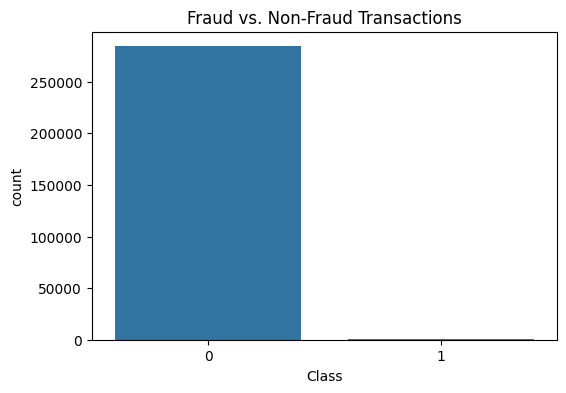

In [4]:
# Data Distribution and Count
counts = df['Class'].value_counts()
print(counts)
print(counts / len(df) * 100)
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df)
plt.title('Fraud vs. Non-Fraud Transactions')
plt.show()

##### Conclusion: Dataset is highely imbalanced.

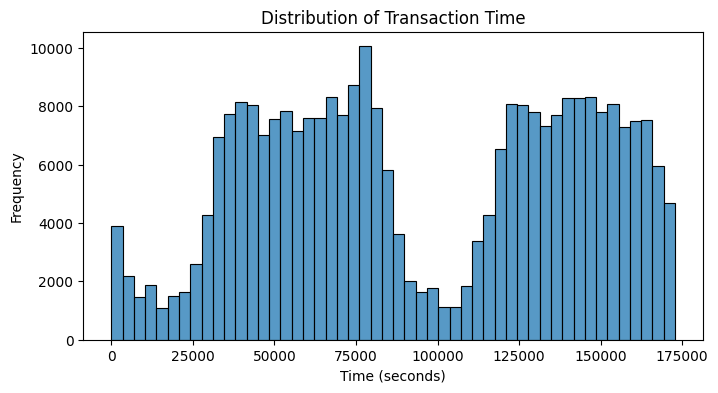

In [5]:
# Distribution of Transaction Time
plt.figure(figsize=(8,4))
sns.histplot(df['Time'], bins=50, kde=False)
plt.title('Distribution of Transaction Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency')
plt.show()

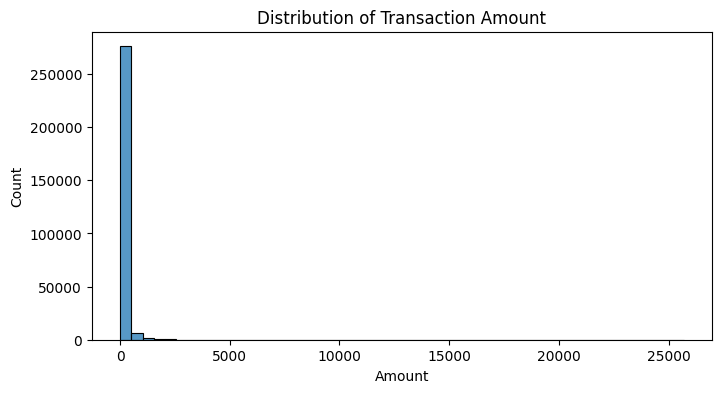

In [6]:
plt.figure(figsize=(8,4))
sns.histplot(df['Amount'], bins=50, kde=False)
plt.title('Distribution of Transaction Amount')
plt.xlabel('Amount')
plt.ylabel('Count')
plt.show()

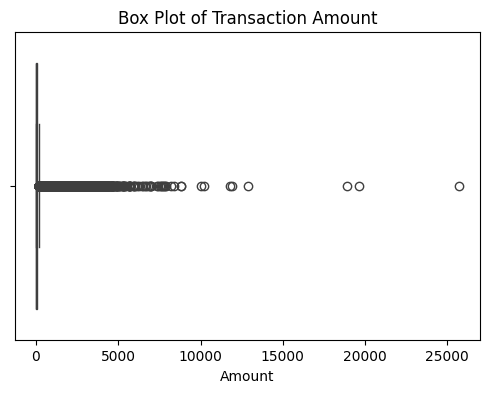

In [7]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df['Amount'])
plt.title('Box Plot of Transaction Amount')
plt.show()

##### Conclusion: The dataset is skewed. There are a lot of small amount transactions in the dataset.

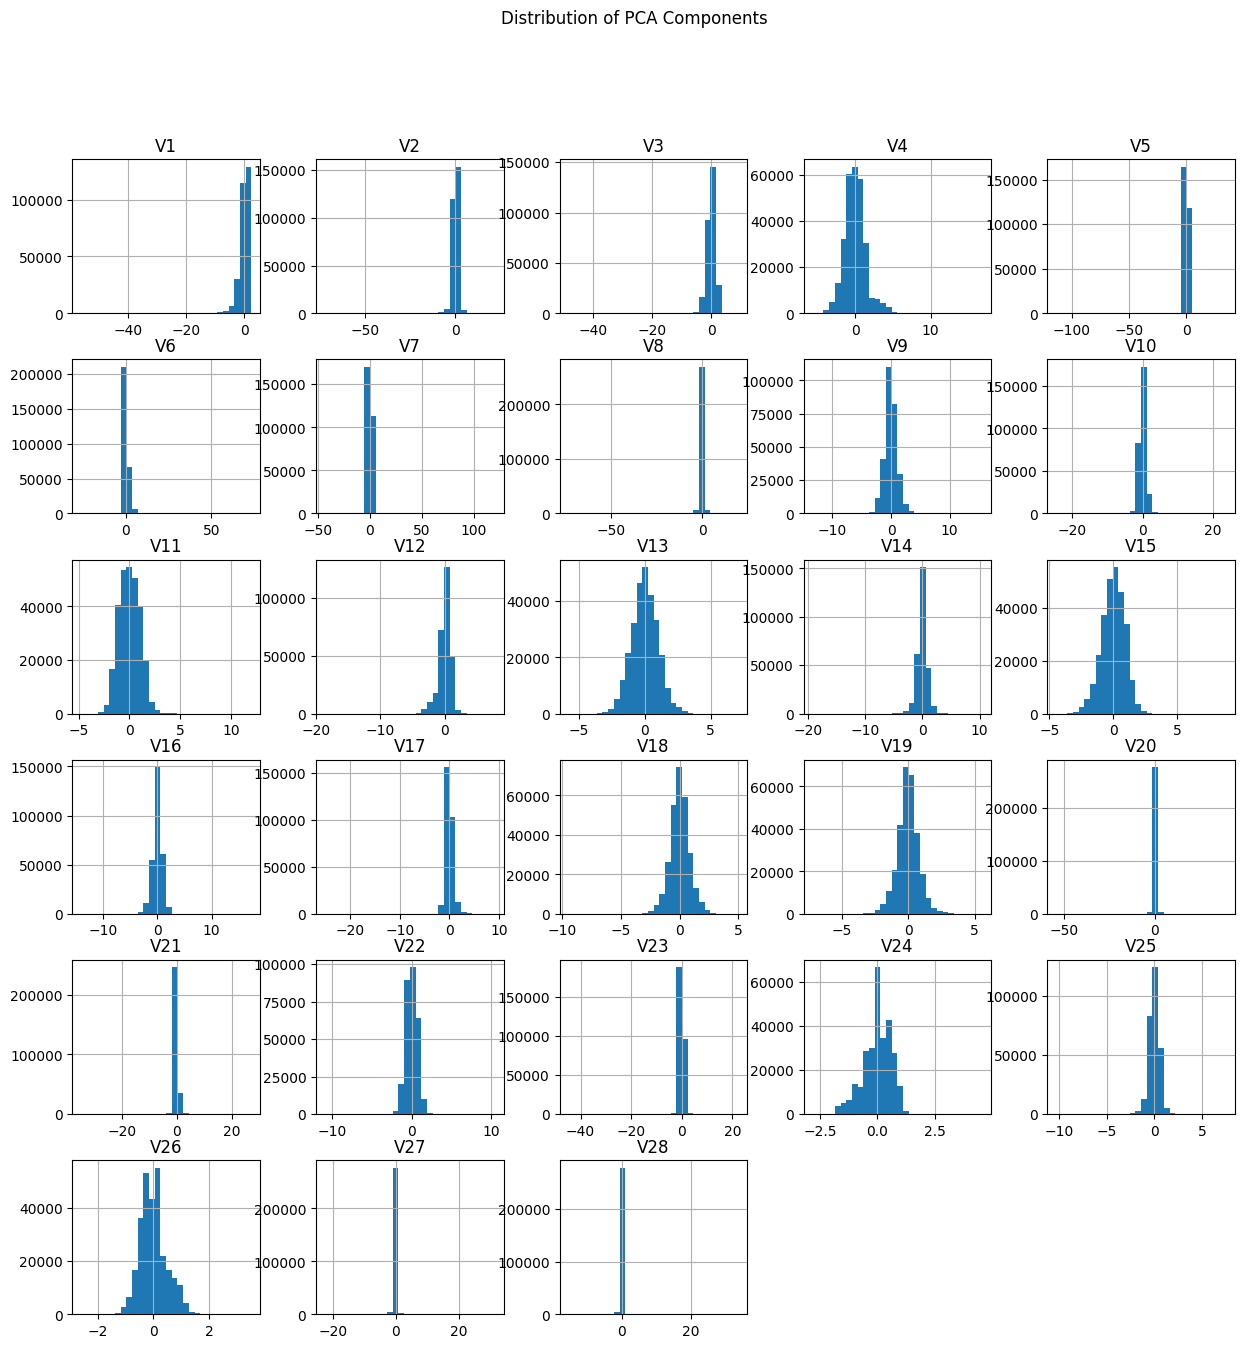

In [8]:
# Plotting the distribution of PCA componenets
pca_features = [f'V{i}' for i in range(1,29)]
df[pca_features].hist(figsize=(15,15), bins=30)
plt.suptitle('Distribution of PCA Components')
plt.show()

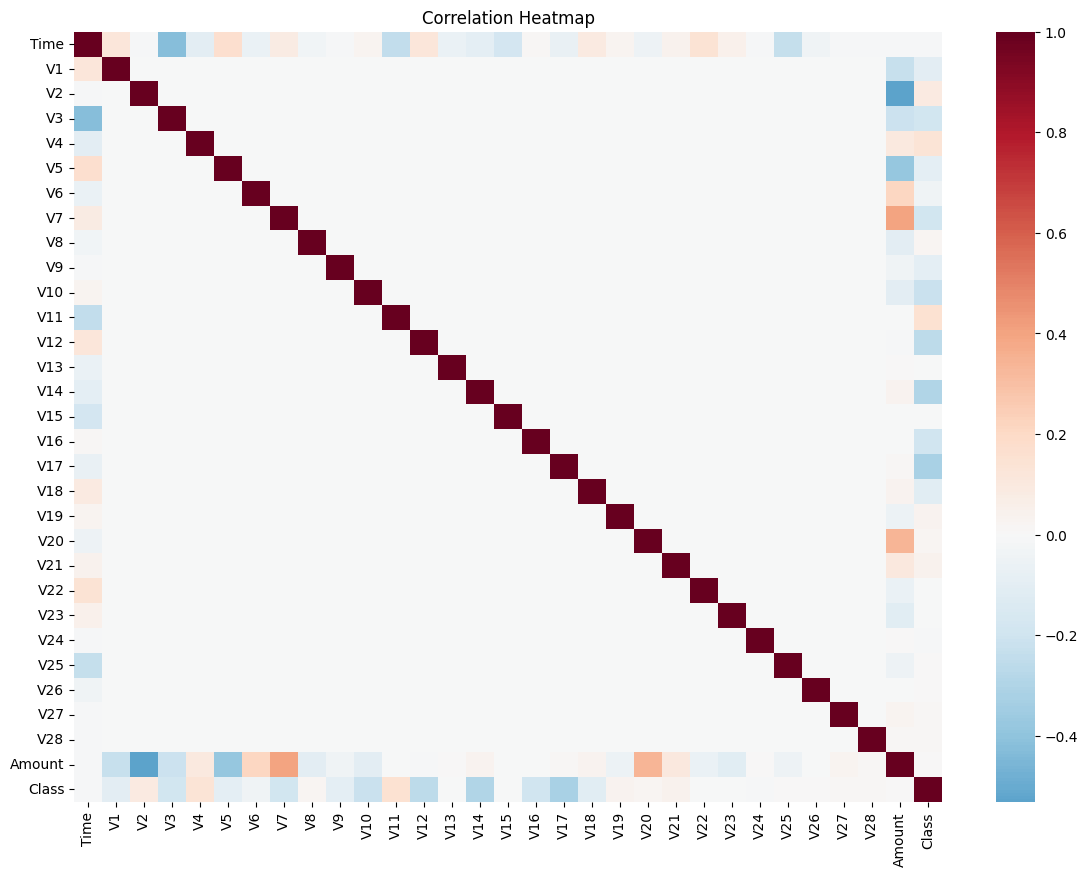

In [9]:
# Correlation Analysis
corr_matrix = df.corr()
plt.figure(figsize=(14,10))
sns.heatmap(corr_matrix, cmap='RdBu_r', center=0)
plt.title('Correlation Heatmap')
plt.show()

##### Conclusion: The histograms of the principal component features (V1–V28) reveal that most components are centered around zero with varying degrees of spread. the heatmap and correlation table provide evidence that the dataset’s principal components are largely orthogonal, and the target variable (Class) does not exhibit strong correlation with any single feature

#### b. Modelling

In [10]:
# Prepare the data and scale it.
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

##### Conclusion:  Some features (V1–V28) are already from PCA, but we often still scale the entire feature set (including Time and Amount) to ensure consistency for distance-based methods.

In [22]:
k_values = [1, 2, 3]
best_kmeans_score = -np.inf
best_kmeans_params = None

for k in k_values:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    km.fit(X_train_scaled)
    cluster_labels = km.predict(X_test_scaled)
    
    # Distance to nearest centroid
    distances = []
    for i, x in enumerate(X_test_scaled):
        c = cluster_labels[i]
        center = km.cluster_centers_[c]
        dist = np.linalg.norm(x - center)
        distances.append(dist)
    distances = np.array(distances)
    
    # Set threshold = top 5% of distances
    threshold = np.percentile(distances, 95)
    # Convert to 1 if distance > threshold
    y_pred_km = (distances > threshold).astype(int)
    
    precision_km = precision_score(y_test, y_pred_km)
    recall_km = recall_score(y_test, y_pred_km)
    f1_km = f1_score(y_test, y_pred_km)
    auc_km = roc_auc_score(y_test, distances)  # higher distance => more likely fraud
    
    if auc_km > best_kmeans_score:
        best_kmeans_score = auc_km
        best_kmeans_params = (k, precision_km, recall_km, f1_km, auc_km)

print(f"Best K-Means config -> k={best_kmeans_params[0]}")
print("Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}, AUC: {:.4f}".format(
    best_kmeans_params[1], best_kmeans_params[2],
    best_kmeans_params[3], best_kmeans_params[4]
))

Best K-Means config -> k=3
Precision: 0.0293, Recall: 0.8446, F1: 0.0565, AUC: 0.9458


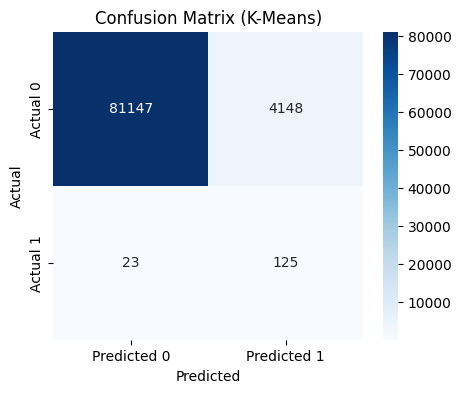

In [17]:
cm_kmeans = confusion_matrix(y_test, y_pred_km)

# Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_kmeans, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix (K-Means)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [20]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

print("Before Resampling -> Fraud %:", np.mean(y_train)*100)
print("After Resampling  -> Fraud %:", np.mean(y_train_res)*100)

Before Resampling -> Fraud %: 0.17254870488152324
After Resampling  -> Fraud %: 50.0


In [15]:
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'lbfgs']
}

lr = LogisticRegression(random_state=42, max_iter=200)

grid_search_lr = GridSearchCV(
    estimator=lr,
    param_grid=param_grid_lr,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search_lr.fit(X_train_res, y_train_res)

print("Best Params:", grid_search_lr.best_params_)
best_lr = grid_search_lr.best_estimator_

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}


In [16]:
y_pred_lr = best_lr.predict(X_test_scaled)
y_prob_lr = best_lr.predict_proba(X_test_scaled)[:, 1]  # Probability of class 1 (fraud)

precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, y_prob_lr)

print(f"Supervised Logistic Regression:")
print(f"  Precision: {precision_lr:.4f}")
print(f"  Recall:    {recall_lr:.4f}")
print(f"  F1-Score:  {f1_lr:.4f}")
print(f"  ROC-AUC:   {auc_lr:.4f}")

Supervised Logistic Regression:
  Precision: 0.0645
  Recall:    0.8784
  F1-Score:  0.1203
  ROC-AUC:   0.9672


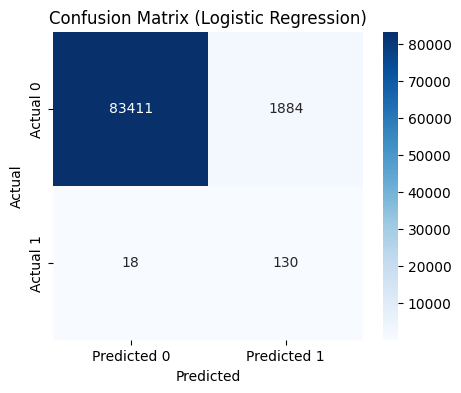

In [18]:
cm_lr = confusion_matrix(y_test, y_pred_lr)

# Plot the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix (Logistic Regression)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

##### Conclusion:
 1. Unsupervised Learning Method: Using KMean algorithm to caculate the distance between the points. The higher the distance, the more likely to be fraud.
 2. Resampling: Using a resampling method like SMOTE to solve the imbalanced data issue. this step will help with the supervised learning approach.
 3. Supervised Learning Method: Using logistic regression to predict if the transaction is fraud or not. this is a basic binary classification problem. so, predicting 1 is a fraud transaction 0 is legit transaction.
 4. Comparing Supervised vs Unsupervised methods:

| Algorithm | Precision | Recall | F1 | AUC |
| --- | --- | --- | --- | --- |
| K-Means (k=3) | 0.0293 | 0.8446 | 0.0565 | 0.9458 |
| Logistic Regression | 0.0645 | 0.8784 | 0.1203 | 0.9672 |

Logistic Regression is clearly performing better overall than K-Means. While both approaches achieve high recall, Logistic Regression posts higher precision, F1-score, and AUC. This indicates that it not only catches a large share of fraud but also reduces false positives more effectively. The supervised approach benefits from labeled data and SMOTE resampling, resulting in more balanced training and better discrimination between fraudulent and legitimate transactions.